<a href="https://colab.research.google.com/github/makoto0825/image_retrieval/blob/main/image_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check the GPU

In [ ]:
!nvidia-smi

Sat Jul 15 02:18:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import optimizers,regularizers
import random
from keras.layers import Dense, Lambda
from tensorflow.keras import losses,optimizers,metrics,Model,layers,applications
from tensorflow.keras.applications import resnet
import zipfile
import shutil
import pickle
#ResNet50
from tensorflow.keras.applications.resnet import ResNet50

target_shape = (200, 200)

Unzip and save image zip file locally from google drive

In [ ]:
# folder names
folder_names = ["img/DRESSES", "img/TOPS", "img/TROUSERS"]

# create a folder in the current directory
for folder_name in folder_names:
    os.makedirs(folder_name, exist_ok=True)

# source ZIP file path
zip_file_paths = [
    "/content/drive/MyDrive/Project_model2/zips/DRESSES.zip",
    "/content/drive/MyDrive/Project_model2/zips/TOPS.zip",
    "/content/drive/MyDrive/Project_model2/zips/TROUSERS.zip"
]

# destination
extract_dir_path = ['/content/img/DRESSES','/content/img/TOPS','/content/img/TROUSERS']

for item1, item2 in zip(zip_file_paths,extract_dir_path):
    with zipfile.ZipFile(item1, 'r') as zip_ref:
        zip_ref.extractall(item2)

create a df with the path of each file

In [ ]:
#Get image file path and create dataframe
direc = Path('img')
filepaths = list(direc.glob(r'**/**/**/*.jpg'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
filepaths = pd.Series(filepaths, name='anchor').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)
img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)


In [ ]:
img_df

anchor       Labels
0         img/TOPS/Lace_Shirt/id_00011708/comsumer_06.jpg  id_00011708
1         img/TOPS/Lace_Shirt/id_00011708/comsumer_02.jpg  id_00011708
2         img/TOPS/Lace_Shirt/id_00011708/comsumer_01.jpg  id_00011708
3         img/TOPS/Lace_Shirt/id_00011708/comsumer_07.jpg  id_00011708
4             img/TOPS/Lace_Shirt/id_00011708/shop_01.jpg  id_00011708
...                                                   ...          ...
226975  img/TROUSERS/Summer_Wear/id_00005817/comsumer_...  id_00005817
226976  img/TROUSERS/Summer_Wear/id_00005817/comsumer_...  id_00005817
226977  img/TROUSERS/Summer_Wear/id_00005817/comsumer_...  id_00005817
226978  img/TROUSERS/Summer_Wear/id_00005817/comsumer_...  id_00005817
226979  img/TROUSERS/Summer_Wear/id_00005817/comsumer_...  id_00005817

[226980 rows x 2 columns]

Create Labels

In [ ]:
#Add column for small category(Label1)
fp = filepaths.str.split(pat="/", n = 8, expand = True)
Label1 = fp[1]+" - "+fp[2]
Label1 = pd.DataFrame(Label1)
Label1 = Label1.rename(columns = {0:'Label1'})
img_df2 = pd.concat([img_df, Label1], axis=1)

In [ ]:
img_df2

anchor       Labels  \
0            img/TOPS/Chiffon/id_00010439/shop_01.jpg  id_00010439   
1        img/TOPS/Chiffon/id_00010439/comsumer_01.jpg  id_00010439   
2            img/TOPS/Chiffon/id_00022659/shop_01.jpg  id_00022659   
3        img/TOPS/Chiffon/id_00022659/comsumer_01.jpg  id_00022659   
4        img/TOPS/Chiffon/id_00022659/comsumer_02.jpg  id_00022659   
...                                               ...          ...   
226975  img/DRESSES/Dress/id_00020261/comsumer_03.jpg  id_00020261   
226976  img/DRESSES/Dress/id_00020261/comsumer_04.jpg  id_00020261   
226977  img/DRESSES/Dress/id_00020261/comsumer_05.jpg  id_00020261   
226978      img/DRESSES/Dress/id_00028039/shop_01.jpg  id_00028039   
226979  img/DRESSES/Dress/id_00028039/comsumer_01.jpg  id_00028039   

                 Label1  
0        TOPS - Chiffon  
1        TOPS - Chiffon  
2        TOPS - Chiffon  
3        TOPS - Chiffon  
4        TOPS - Chiffon  
...                 ...  
226975  DRESSES - Dress  
226976  DRESSES - Dress  
226977  DRESSES - Dress  
226978  DRESSES - Dress  
226979  DRESSES - Dress  

[226980 rows x 3 columns]

Create DFs for training, validation, and testing

In [ ]:
# Get excel file
file_path = "/content/drive/MyDrive/Project_model2/list_eval_partition.xlsx"
list_eval_partition_df = pd.read_excel(file_path, sheet_name="kind")

# Create  train, val and test
img_df2 = pd.merge(img_df2, list_eval_partition_df, on='Labels', how='left')
train_df = img_df2[img_df2['kind'] == 'train']
val_df = img_df2[img_df2['kind'] == 'val']
test_df = img_df2[img_df2['kind'] == 'test']

# remove shop image
train_df = train_df[~train_df['anchor'].str.contains('shop_')]
val_df = val_df[~val_df['anchor'].str.contains('shop_')]
test_df = test_df[~test_df['anchor'].str.contains('shop_')]

# Add shop image column
list_eval_partition_df = pd.read_excel(file_path, sheet_name="train")
train_df = pd.merge(train_df, list_eval_partition_df, on='anchor', how='left')
list_eval_partition_df = pd.read_excel(file_path, sheet_name="val")
val_df = pd.merge(val_df, list_eval_partition_df, on='anchor', how='left')
list_eval_partition_df = pd.read_excel(file_path, sheet_name="test")
test_df = pd.merge(test_df, list_eval_partition_df, on='anchor', how='left')

#remove duplicate rows
train_df.drop_duplicates(subset=['anchor'], keep='first', inplace=True)
val_df.drop_duplicates(subset=['anchor'], keep='first', inplace=True)
test_df.drop_duplicates(subset=['anchor'], keep='first', inplace=True)

In [ ]:
train_df

anchor       Labels  \
0       img/TOPS/Chiffon/id_00010439/comsumer_01.jpg  id_00010439   
1       img/TOPS/Chiffon/id_00017618/comsumer_01.jpg  id_00017618   
2       img/TOPS/Chiffon/id_00014132/comsumer_01.jpg  id_00014132   
3       img/TOPS/Chiffon/id_00014132/comsumer_02.jpg  id_00014132   
4       img/TOPS/Chiffon/id_00028287/comsumer_01.jpg  id_00028287   
...                                              ...          ...   
94381  img/DRESSES/Dress/id_00020261/comsumer_02.jpg  id_00020261   
94382  img/DRESSES/Dress/id_00020261/comsumer_03.jpg  id_00020261   
94383  img/DRESSES/Dress/id_00020261/comsumer_04.jpg  id_00020261   
94384  img/DRESSES/Dress/id_00020261/comsumer_05.jpg  id_00020261   
94385  img/DRESSES/Dress/id_00028039/comsumer_01.jpg  id_00028039   

                Label1   kind                                   positive  \
0       TOPS - Chiffon  train   img/TOPS/Chiffon/id_00010439/shop_01.jpg   
1       TOPS - Chiffon  train   img/TOPS/Chiffon/id_00017618/shop_01.jpg   
2       TOPS - Chiffon  train   img/TOPS/Chiffon/id_00014132/shop_01.jpg   
3       TOPS - Chiffon  train   img/TOPS/Chiffon/id_00014132/shop_01.jpg   
4       TOPS - Chiffon  train   img/TOPS/Chiffon/id_00028287/shop_01.jpg   
...                ...    ...                                        ...   
94381  DRESSES - Dress  train  img/DRESSES/Dress/id_00020261/shop_01.jpg   
94382  DRESSES - Dress  train  img/DRESSES/Dress/id_00020261/shop_01.jpg   
94383  DRESSES - Dress  train  img/DRESSES/Dress/id_00020261/shop_01.jpg   
94384  DRESSES - Dress  train  img/DRESSES/Dress/id_00020261/shop_01.jpg   
94385  DRESSES - Dress  train  img/DRESSES/Dress/id_00028039/shop_01.jpg   

                ID     種類  
0      id_00010439  train  
1      id_00017618  train  
2      id_00014132  train  
3      id_00014132  train  
4      id_00028287  train  
...            ...    ...  
94381  id_00020261  train  
94382  id_00020261  train  
94383  id_00020261  train  
94384  id_00020261  train  
94385  id_00028039  train  

[93758 rows x 7 columns]

excel output

In [ ]:
# excel output
# output_file_path = "train_df.xlsx"
# train_df.to_excel(output_file_path, index=False)
# excel output
# output_file_path = "val_df.xlsx"
# val_df.to_excel(output_file_path, index=False)
# excel output
# output_file_path = "test_df.xlsx"
# test_df.to_excel(output_file_path, index=False)

check the image

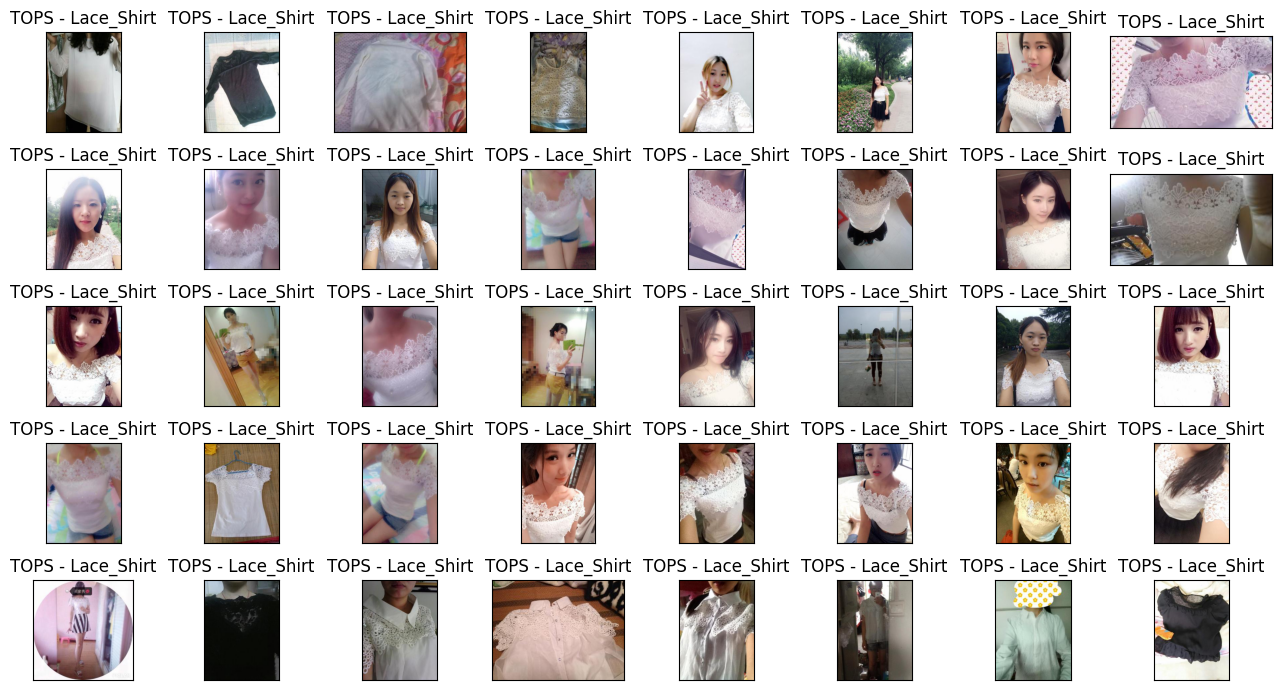

In [ ]:
import matplotlib.pyplot as plt
f,a = plt.subplots(nrows=5, ncols=8,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(train_df.anchor[i]))
    ax.set_title(train_df.Label1[i])

plt.tight_layout()
plt.show()

Create dataset in TensorFlow

In [ ]:
#================================================Functions for image preprocessing======================================================
target_shape = (200, 200)
def preprocess_image(filename, target_shape=target_shape):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """
    img_str = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img_str, channels=3)
    img = tf.image.resize(img, target_shape)

    # Resnet-style preprocessing, see: https://git.io/JYo77
    mean = [103.939, 116.779, 123.68]
    img = img[..., ::-1]
    img -= mean

    return img


def preprocess_triplets(anchor, positive, negative):
    """
Given the filenames corresponding to the three images, load them and preprocess them.
    """
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [ ]:
# Function to create triplet images
def create_triplets(data):
    anchor_images = []
    positive_images = []
    negative_images = []

    for anchor_index, row in data.iterrows():

        #insert positive
        anchor = row['anchor']
        anchor_images.append(anchor)
        #insert  positive
        positive = row['positive']
        positive_images.append(positive)
        #Randomly select negative examples of different classes (hard negatives)
        label = row['Label1']
        id = row['Labels']
        negative_candidates = data[(data['Label1'] == label) & (data['Labels'] != id)]['positive'].tolist()
        negative = random.choice(negative_candidates)
        negative_images.append(negative)

    return anchor_images,positive_images,negative_images

In [ ]:
#==========================================Create Train data set======================================
# create triplet list
x_train_anchor_images,x_train_positive_images,x_train_negative_images, = create_triplets(train_df)
# Create a dataset object for each TensorFlow
x_train_anchor_dataset = tf.data.Dataset.from_tensor_slices(x_train_anchor_images)
x_train_positive_dataset = tf.data.Dataset.from_tensor_slices(x_train_positive_images)
x_train_negative_dataset = tf.data.Dataset.from_tensor_slices(x_train_negative_images)
# Combine three datasets
train_dataset = tf.data.Dataset.zip((x_train_anchor_dataset, x_train_positive_dataset, x_train_negative_dataset))
# A set of operations that preprocesses a triplet-format dataset, batches it, and prefetches the data for speed.
train_dataset = train_dataset.shuffle(buffer_size=1024)
train_dataset = train_dataset.map(preprocess_triplets)
train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

In [ ]:
#==========================================save triplet list======================================
# import pickle

# Destination folder path
# save_folder = '/content/drive/MyDrive/Project_model2/pkl_files/create_triplets/train'
# #save anchor
# with open(os.path.join(save_folder, 'x_train_anchor_images.pkl'), 'wb') as f:
#     pickle.dump(x_train_anchor_images, f)
# #save positive
# with open(os.path.join(save_folder, 'x_train_positive_images.pkl'), 'wb') as f:
#     pickle.dump(x_train_positive_images, f)
# #save negative
# with open(os.path.join(save_folder, 'x_train_negative_images.pkl'), 'wb') as f:
#     pickle.dump(x_train_negative_images, f)

In [ ]:
#==========================================load triplet list======================================
# import os
# file_path = '/content/drive/MyDrive/Project_model2/pkl_files/create_triplets/train/x_train_anchor_images.pkl'
# #load anchor
# with open(file_path, 'rb') as file:
#     x_train_anchor_images = pickle.load(file)
# #load positive
# file_path = '/content/drive/MyDrive/Project_model2/pkl_files/create_triplets/train/x_train_positive_images.pkl'
# with open(file_path, 'rb') as file:
#     x_train_positive_images = pickle.load(file)
# #load negative
# file_path = '/content/drive/MyDrive/Project_model2/pkl_files/create_triplets/train/x_train_negative_images.pkl'
# with open(file_path, 'rb') as file:
#     x_train_negative_images = pickle.load(file)

In [ ]:
#==========================================Create validationdata set======================================
# create triplet list
x_val_anchor_images,x_val_positive_images,x_val_negative_images, = create_triplets(val_df)
# Create a dataset object for each TensorFlow
x_val_anchor_dataset = tf.data.Dataset.from_tensor_slices(x_val_anchor_images)
x_val_positive_dataset = tf.data.Dataset.from_tensor_slices(x_val_positive_images)
x_val_negative_dataset = tf.data.Dataset.from_tensor_slices(x_val_negative_images)
# Combine three datasets
val_dataset = tf.data.Dataset.zip((x_val_anchor_dataset, x_val_positive_dataset, x_val_negative_dataset))
# A set of operations that preprocesses a triplet-format dataset, batches it, and prefetches the data for speed.
val_dataset = val_dataset.shuffle(buffer_size=1024)
val_dataset = val_dataset.map(preprocess_triplets)
val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [ ]:
#==========================================save triplet list======================================
# Destination folder path
# save_folder = '/content/drive/MyDrive/Project_model2/pkl_files/create_triplets/val'
# #save anchor
# with open(os.path.join(save_folder, 'x_val_anchor_images.pkl'), 'wb') as f:
#     pickle.dump(x_val_anchor_images, f)
# #save positive
# with open(os.path.join(save_folder, 'x_val_positive_images.pkl'), 'wb') as f:
#     pickle.dump(x_val_positive_images, f)
# #save negative
# with open(os.path.join(save_folder, 'x_val_negative_images.pkl'), 'wb') as f:
#     pickle.dump(x_val_negative_images, f)

In [ ]:
#==========================================load triplet list======================================
file_path = '/content/drive/MyDrive/Project_model2/pkl_files/create_triplets2/val/x_val_anchor_images.pkl'
# #load anchor
with open(file_path, 'rb') as file:
    x_val_anchor_images = pickle.load(file)
# #load positive
file_path = '/content/drive/MyDrive/Project_model2/pkl_files/create_triplets/val/x_val_positive_images.pkl'
with open(file_path, 'rb') as file:
    x_val_positive_images = pickle.load(file)
# #load negative
file_path = '/content/drive/MyDrive/Project_model2/pkl_files/create_triplets/val/x_val_negative_images.pkl'
with open(file_path, 'rb') as file:
    x_val_negative_images = pickle.load(file)

Anchor: b'img/TOPS/Tank_Top/id_00027032/comsumer_02.jpg'
Positive: b'img/TOPS/Tank_Top/id_00027032/shop_02.jpg'
Negative: b'img/TOPS/Tank_Top/id_00013911/shop_01.jpg'


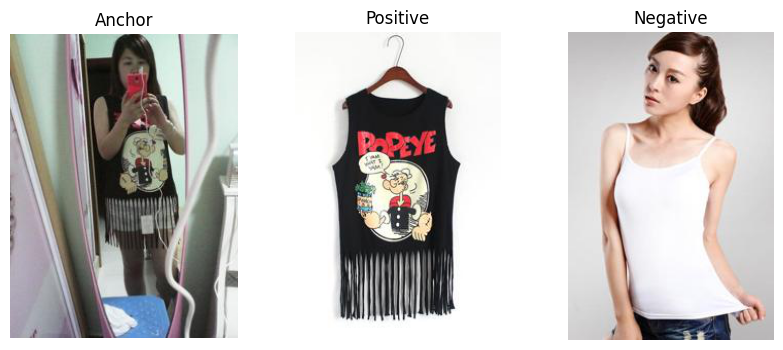

In [ ]:
#==========================================check the image======================================
from PIL import Image
from itertools import islice
# Check the 30001 row element of dataset
row = 30001
iterator = islice(val_dataset.as_numpy_iterator(), row-1, row)
for anchor, positive, negative in iterator:
    print("Anchor:", anchor)
    print("Positive:", positive)
    print("Negative:", negative)

# show image
    anchor_image = Image.open(anchor.decode("utf-8"))
    positive_image = Image.open(positive.decode("utf-8"))
    negative_image = Image.open(negative.decode("utf-8"))

    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    axes[0].imshow(anchor_image)
    axes[0].set_title("Anchor")
    axes[0].axis("off")

    axes[1].imshow(positive_image)
    axes[1].set_title("Positive")
    axes[1].axis("off")

    axes[2].imshow(negative_image)
    axes[2].set_title("Negative")
    axes[2].axis("off")

    plt.show()


training

In [ ]:
#==========================================class calculate the distance======================================
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

#==========================================Architecture ======================================
base_cnn = resnet.ResNet50(
      weights="imagenet", input_shape=target_shape + (3,), include_top=False, pooling='avg',
    )
dropout = layers.Dropout(0.5, name='dropout')
reduce = layers.Dense(512, activation='linear', name='reduce')

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    reduce(dropout(base_cnn(anchor_input))),
    reduce(dropout(base_cnn(positive_input))),
    reduce(dropout(base_cnn(negative_input))),
    )

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances)

siamese_network.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative (InputLayer)          [(None, 200, 200, 3  0           []                               
                             

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.
    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.
    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """
    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
hist = siamese_model.fit(train_dataset, epochs=10,validation_data=val_dataset)


Epoch 1/10
2930/2930 [==============================] - ETA: 0s - loss: 0.3855

2930/2930 [==============================] - 230s 70ms/step - loss: 0.3855 - val_loss: 0.2466
Epoch 2/10
2930/2930 [==============================] - ETA: 0s - loss: 0.1390

2930/2930 [==============================] - 201s 69ms/step - loss: 0.1390 - val_loss: 0.2158
Epoch 3/10
2930/2930 [==============================] - ETA: 0s - loss: 0.1060

2930/2930 [==============================] - 202s 69ms/step - loss: 0.1060 - val_loss: 0.2496
Epoch 4/10
2930/2930 [==============================] - ETA: 0s - loss: 0.0804

2930/2930 [==============================] - 202s 69ms/step - loss: 0.0804 - val_loss: 0.2188
Epoch 5/10
2930/2930 [==============================] - ETA: 0s - loss: 0.0582

2930/2930 [==============================] - 202s 69ms/step - loss: 0.0582 - val_loss: 0.2645
Epoch 6/10
2930/2930 [==============================] - ETA: 0s - loss: 0.0428

2930/2930 [==============================] - 202s 69ms/step - loss: 0.0428 - val_loss: 0.2543
Epoch 7/10
2930/2930 [==============================] - ETA: 0s - loss: 0.0324

2930/2930 [==============================] - 202s 69ms/step - loss: 0.0324 - val_loss: 0.2420
Epoch 8/10
2930/2930 [==============================] - ETA: 0s - loss: 0.0286

2930/2930 [==============================] - 202s 69ms/step - loss: 0.0286 - val_loss: 0.2693
Epoch 9/10
2930/2930 [==============================] - ETA: 0s - loss: 0.0238

2930/2930 [==============================] - 202s 69ms/step - loss: 0.0238 - val_loss: 0.2815
Epoch 10/10
2930/2930 [==============================] - ETA: 0s - loss: 0.0216

2930/2930 [==============================] - 202s 69ms/step - loss: 0.0216 - val_loss: 0.2789


In [ ]:
#==========================================save file======================================
encoder = tf.keras.Sequential([
    siamese_model.siamese_network.get_layer('resnet50'),
    siamese_model.siamese_network.get_layer('dropout'),
    siamese_model.siamese_network.get_layer('reduce'),
    ])

encoder.save('drive/My Drive/Project_model2/model2/encoder.h5')
siamese_model.save_weights('drive/My Drive/Project_model2/model2/siamese_model.h5')
siamese_model.siamese_network.save_weights('drive/My Drive/Project_model2/model2/siamese_network.h5')
siamese_model.siamese_network.get_layer('resnet50').save_weights('drive/My Drive/Project_model2/model2/esnet50.h5')

Get database images features

In [ ]:
#================================================Move database images from google drive to local======================================================
#create a empty　folder in the current directory
folder_name = "Database"
os.makedirs(folder_name, exist_ok=True)

# source ZIP file path
zip_file_path = "/content/drive/MyDrive/Project_model2/Database.zip"

# directory path to unzip
extract_dir_path = "/content/Database"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir_path)


In [ ]:
#================================================read the trained model======================================================
from tensorflow.keras.models import load_model
embedding = load_model('drive/My Drive/Project_model2/model2/encoder.h5')
embedding.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 reduce (Dense)              (None, 512)               1049088   
                                                                 
Total params: 24,636,800
Trainable params: 9,980,416
Non-trainable params: 14,656,384
_________________________________________________________________


In [ ]:
#================================================Get database images features ======================================================
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input

# database folder path
folder_path  = '/content/Database'

#cerate list
subfolders = []
features_list = []
file_names = []

# Function to get the lowest folder path
def get_bottom_folders(folder):
    subfolders = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            subfolders.extend(get_bottom_folders(subfolder_path))
        else:
            subfolders.append(subfolder_path)
    return subfolders

# Get the lowest folder path
subfolders = get_bottom_folders(folder_path)

# Get features
for subfolder in subfolders:
  img = image.load_img(subfolder, target_size=(200, 200))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = embedding.predict(x)
  features_list.append(features)
  file_names.append(subfolder)

In [ ]:
#================================================Save database features ======================================================
# import pickle

# # # Destination folder path
# save_folder = '/content/drive/MyDrive/Project_model2/pkl_files/Database/model2'
# # # save features_list
# with open(os.path.join(save_folder, 'features_list_1.pkl'), 'wb') as f:
#     pickle.dump(features_list, f)
# # # save file_names
# with open(os.path.join(save_folder, 'file_names_1.pkl'), 'wb') as f:
#     pickle.dump(file_names, f)

In [ ]:
#================================================Load features if they already exist ======================================================

import pickle
import os

file_path = '/content/drive/MyDrive/Project_model2/pkl_files/Database/model2/features_list_1.pkl'
# load the pickle file
with open(file_path, 'rb') as file:
    features_list = pickle.load(file)

file_path = '/content/drive/MyDrive/Project_model2/pkl_files/Database/model2/file_names_1.pkl'
# load the pickle file
with open(file_path, 'rb') as file:
    file_names = pickle.load(file)


Get query image features

In [ ]:
#================================================read the trained model======================================================
from tensorflow.keras.models import load_model
query_model = load_model('drive/My Drive/Project_model2/model2/encoder.h5')
query_model.summary()
query_model.trainable = False

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 reduce (Dense)              (None, 512)               1049088   
                                                                 
Total params: 24,636,800
Trainable params: 9,980,416
Non-trainable params: 14,656,384
_________________________________________________________________


In [ ]:
#================================================Get query image features ======================================================

from tensorflow.python import summary
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input

# Query image path
folder_path2 = 'drive/My Drive/Project_model2/Query_images2'
# Get path of Query image in folder
query_paths = [os.path.join(folder_path2, file_name) for file_name in os.listdir(folder_path2)]


# List to store image feature vectors and file names
query_features_list = []
query_file_names = []

# Get features
for image_path in query_paths:
    img = image.load_img(image_path, target_size=(200, 200))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = query_model.predict(x)
    query_features_list.append(features)
    query_file_names.append(os.path.basename(image_path))

1/1 [==============================] - 0s 102ms/step


image retrieval

In [ ]:
#================================================Similarity calculation df=====================================================

# Compute Cosine Similarity
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
#Return the index sorted in descending order of similarity
def get_top_n_indexes(array, num):
    idx = np.argpartition(array, -num)[-num:]
    return idx[np.argsort(array[idx])][::-1]

def search(query_vector, features,file_names, num):
    sims = []
    for vector in features:
        sim = cos_sim(query_vector.flatten(), vector.flatten())
        sims.append(sim)
    sims = np.array(sims)
    indexes = get_top_n_indexes(sims, num)
    names = [file_names[i] for i in indexes]
    return indexes, sims[indexes],names

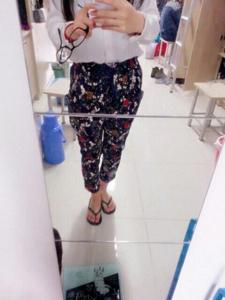

In [ ]:
#=================================================Perform similarity calculations====================================================

import cv2
from google.colab.patches import cv2_imshow
# Sst the query image you want to search
target_filename = 'query_13.jpg'
index = query_file_names.index(target_filename)

# combine image paths
query_paths = os.path.join(folder_path2, target_filename)
#load the image
image = cv2.imread(query_paths)
#show query image
cv2_imshow(image)

#Perform similarity calculations
results, sims,names = search(query_features_list[index], features_list,file_names, 20)

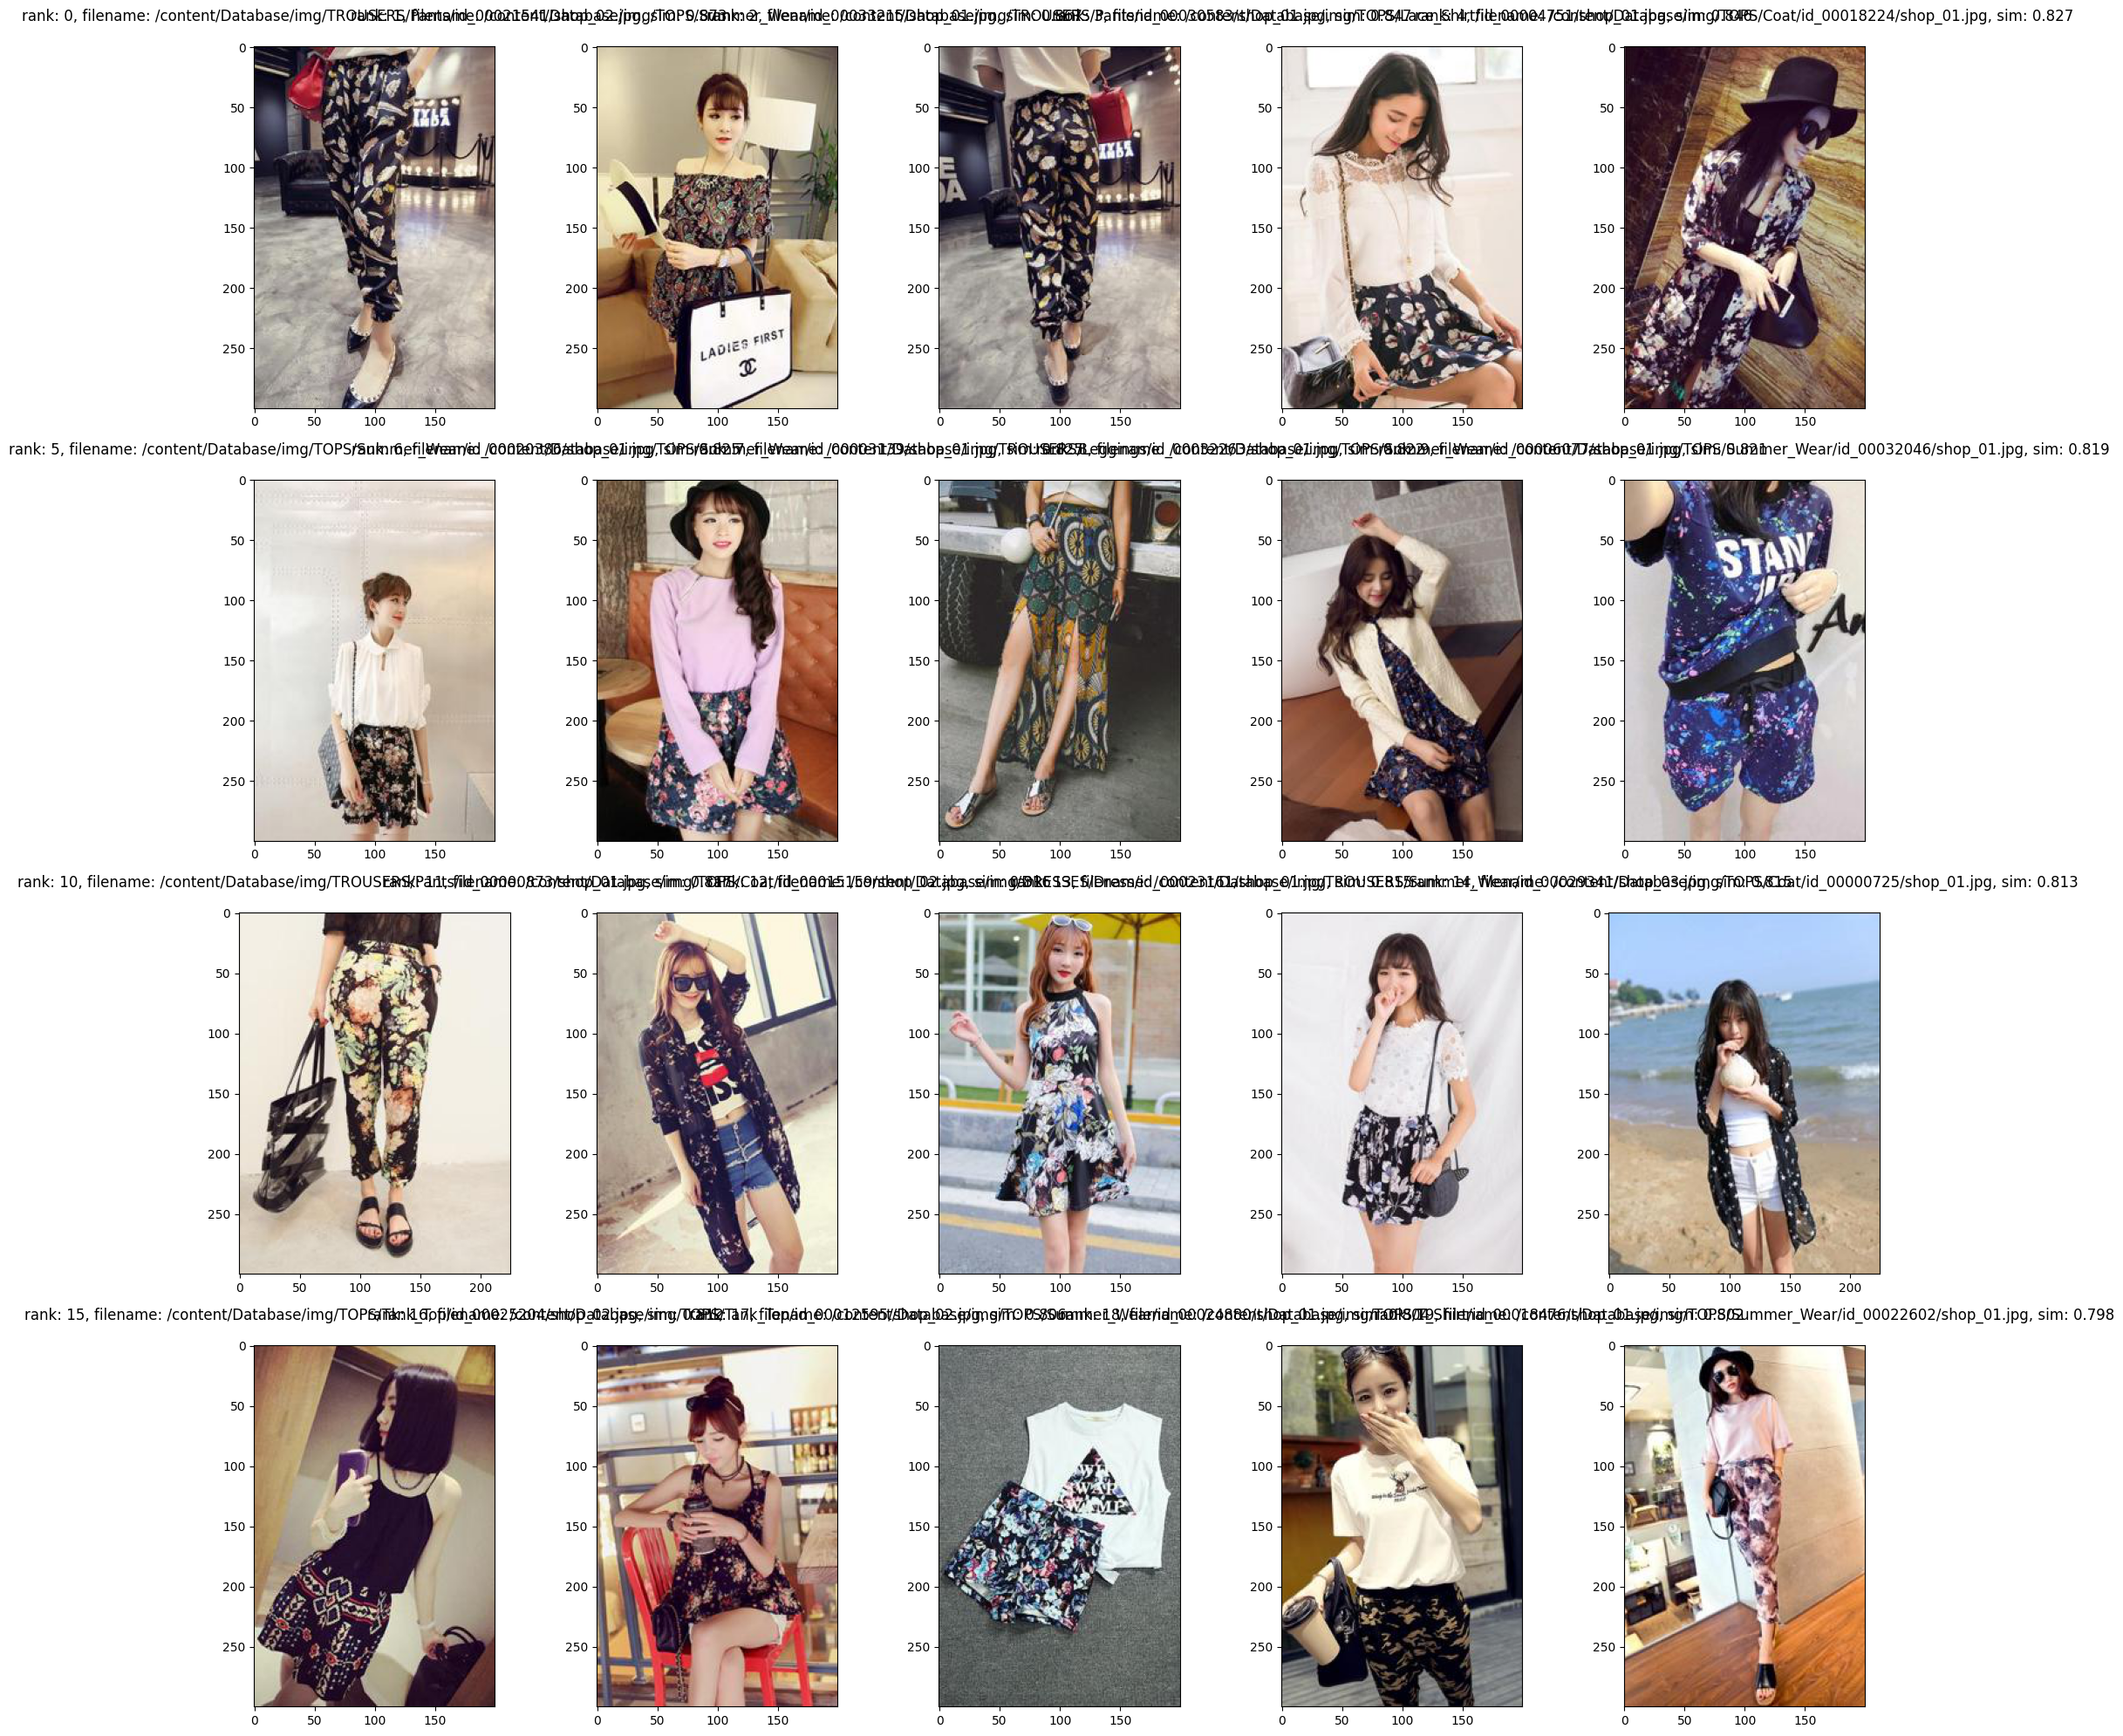

In [ ]:
#=================================================Output images with high similarity (top20)====================================================

from PIL import Image
def show_results(results, sims):
    rank = 0
    plt.figure(figsize=(20, 20))

    for filename, sim in zip(results, sims):
        plt.subplot(4, 5, rank + 1)
        title = f"rank: {rank}, filename: {filename}, sim: {sim:.3f}\n"
        plt.title(title)
        img = Image.open(filename)
        plt.imshow(img)
        rank += 1

    plt.tight_layout()
    plt.show()

show_results(names, sims)


In [ ]:
def count_partial_dresses(names):
    count = 0
    for name in names:
        if "img/TOPS" in name:
            count += 1
    return count
count_partial_dresses(names)

13